In [4]:
# Import necessary libraries
import pandas as pd
import logging
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [17]:
import logging
import sys

# Create a custom logger
logger = logging.getLogger()

# Set the logging level
logger.setLevel(logging.DEBUG)

# Clear any existing handlers
if logger.hasHandlers():
    logger.handlers.clear()

# Create a handler to output to console
stream_handler = logging.StreamHandler(sys.stdout)
stream_handler.setLevel(logging.DEBUG)

# Create a formatter and add it to the handler
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
stream_handler.setFormatter(formatter)

# Add the handler to the logger
logger.addHandler(stream_handler)

In [18]:
logging.info("This is an info message.")
logging.debug("This is a debug message.")

2024-11-29 20:11:25,128 - INFO - This is an info message.
2024-11-29 20:11:25,131 - DEBUG - This is a debug message.


In [19]:
# Loading dataset
train = pd.read_csv("/kaggle/input/brist1d/train.csv", low_memory=False)
test = pd.read_csv("/kaggle/input/brist1d/test.csv", low_memory=False)

### Data Preprocessing: `time_cycling(df)`

The `time_cycling` function takes a DataFrame `df` with a column called `'time'` (in the format `HH:MM:SS`) and performs the following steps:

1. **Converts the 'time' column to datetime format**:
   - The `time` column in the DataFrame is converted to a pandas `datetime` object using `pd.to_datetime()`. The format of the time is specified as `%H:%M:%S`.

2. **Extracts hours and minutes**:
   - The hours are extracted from the `time` column using `.dt.hour`, and the minutes are extracted using `.dt.minute`.

3. **Applies cyclic transformations (sin and cos)**:
   - **Hour transformation**:
     - The function computes the cyclic representations of the hour using sine (`hour_sin`) and cosine (`hour_cos`).
     - The formulas are:
       - `hour_sin = np.sin(2 * np.pi * hour / 24)`
       - `hour_cos = np.cos(2 * np.pi * hour / 24)`
     - These transformations map hours onto a continuous circular scale, where the values repeat every 24 hours.

   - **Minute transformation**:
     - Similarly, the sine and cosine transformations for the minutes are calculated using the same cyclic formulas:
       - `minute_sin = np.sin(2 * np.pi * minute / 60)`
       - `minute_cos = np.cos(2 * np.pi * minute / 60)`
     - These transformations map minutes onto a continuous circular scale, where values repeat every 60 minutes.

4. **Drops the original 'time' column**:
   - The original `'time'` column is removed from the DataFrame using `df.drop(columns=['time'], inplace=True)` as it is no longer needed.

5. **Returns the modified DataFrame**:
   - The DataFrame with the added cyclic features (`hour_sin`, `hour_cos`, `minute_sin`, and `minute_cos`) is returned.

### Use Case

This function is useful when you want to represent cyclical time features (like hours and minutes) in a machine learning model, ensuring that the model understands the periodic nature of time (e.g., midnight is close to 23:59).


In [20]:
def time_cycling(df):
    time_col = pd.to_datetime(df['time'], format='%H:%M:%S')
    hours = time_col.dt.hour
    minutes = time_col.dt.minute
    df['hour_sin'] = np.sin(2 * np.pi * hours / 24)
    df['hour_cos'] = np.cos(2 * np.pi * hours / 24)
    df['minute_sin'] = np.sin(2 * np.pi * minutes / 60)
    df['minute_cos'] = np.cos(2 * np.pi * minutes / 60)
    df.drop(columns=['time'], inplace=True)
    return df

In [21]:
train = time_cycling(train)
test = time_cycling(test)

### Code Explanation: Data Preprocessing

The provided code performs several preprocessing steps on the `train` DataFrame, including mapping and column dropping. Below is the explanation of each step:
**Mapping 'p_num' to Numeric Values**:
**Dropping the 'id' Column (if it exists)** 

### Purpose

- The primary purpose of this code is to map categorical `p_num` values to numeric values for machine learning models, as most models perform better with numeric features.
- It also ensures that any unnecessary columns like `id` (which may be used as an identifier) are removed from the dataset, preparing it for further analysis or modeling.

In [22]:

# Assuming train is a DataFrame
mapping_dict = {p: idx for idx, p in enumerate(train['p_num'].unique())}

# Map p_num and process time directly
train['p_num'] = train['p_num'].map(mapping_dict)


# Drop the 'id' column if it exists
if 'id' in train.columns:
    train.drop(columns=['id'], inplace=True)

# Output the processed DataFrame for verification
train.head()


,p_num,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,bg-5:20,bg-5:15,...,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00,bg+1:00,hour_sin,hour_cos,minute_sin,minute_cos
0,0,NaN,NaN,9.6,NaN,NaN,9.7,NaN,NaN,9.2,...,NaN,NaN,NaN,NaN,NaN,13.4,1.000000,6.123234e-17,0.866025,0.500000
1,0,NaN,NaN,9.7,NaN,NaN,9.2,NaN,NaN,8.7,...,NaN,NaN,NaN,NaN,NaN,12.8,1.000000,6.123234e-17,0.500000,-0.866025
2,0,NaN,NaN,9.2,NaN,NaN,8.7,NaN,NaN,8.4,...,NaN,NaN,NaN,NaN,NaN,15.5,1.000000,6.123234e-17,-0.866025,-0.500000
3,0,NaN,NaN,8.7,NaN,NaN,8.4,NaN,NaN,8.1,...,NaN,NaN,NaN,NaN,NaN,14.8,1.000000,6.123234e-17,-0.500000,0.866025
4,0,NaN,NaN,8.4,NaN,NaN,8.1,NaN,NaN,8.3,...,NaN,NaN,NaN,NaN,NaN,12.7,0.965926,-2.588190e-01,0.866025,0.500000


In [23]:
import pandas as pd

# Assuming train is a DataFrame
mapping_dict = {p: idx for idx, p in enumerate(test['p_num'].unique())}

# Map p_num and process time directly
test['p_num'] = test['p_num'].map(mapping_dict)

# Output the processed DataFrame for verification
test.head()

,id,p_num,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,bg-5:20,...,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00,hour_sin,hour_cos,minute_sin,minute_cos
0,p01_8459,0,NaN,9.2,NaN,NaN,10.2,NaN,NaN,10.3,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,6.123234e-17,-1.000000e+00,-1.836970e-16
1,p01_8460,0,NaN,NaN,9.9,NaN,NaN,9.4,NaN,NaN,...,NaN,NaN,NaN,Walk,Walk,Walk,0.258819,-9.659258e-01,5.000000e-01,-8.660254e-01
2,p01_8461,0,NaN,5.5,NaN,NaN,5.5,NaN,NaN,5.2,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.500000,-8.660254e-01,-1.000000e+00,-1.836970e-16
3,p01_8462,0,NaN,3.4,NaN,NaN,3.9,NaN,NaN,4.7,...,NaN,NaN,NaN,NaN,NaN,NaN,0.866025,5.000000e-01,5.665539e-16,-1.000000e+00
4,p01_8463,0,NaN,NaN,8.3,NaN,NaN,10.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.866025,5.000000e-01,8.660254e-01,-5.000000e-01


In [24]:
train.sample(5)

,p_num,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,bg-5:20,bg-5:15,...,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00,bg+1:00,hour_sin,hour_cos,minute_sin,minute_cos
147996,7,9.7,9.8,10.3,10.5,10.7,10.5,9.4,9.9,9.5,...,NaN,NaN,NaN,NaN,NaN,12.3,1.224647e-16,-1.000000,0.500000,8.660254e-01
128001,7,12.2,12.4,12.4,12.2,12.2,12.2,12.1,12.0,12.1,...,NaN,NaN,NaN,NaN,NaN,9.7,7.071068e-01,0.707107,0.866025,-5.000000e-01
7857,0,NaN,NaN,7.2,NaN,NaN,5.9,NaN,NaN,5.2,...,NaN,NaN,NaN,NaN,NaN,3.6,-9.659258e-01,-0.258819,1.000000,2.832769e-16
149448,7,8.0,7.8,7.8,7.7,7.7,7.6,7.2,7.3,6.9,...,NaN,NaN,NaN,NaN,NaN,4.4,-2.588190e-01,-0.965926,0.500000,8.660254e-01
106591,6,6.4,6.6,6.6,6.5,6.4,5.5,5.2,5.3,5.4,...,NaN,NaN,NaN,NaN,NaN,5.7,2.588190e-01,-0.965926,0.500000,8.660254e-01


### Code Overview: Activity Column Processing

1. **Identifying Activity Columns**:
   - The code identifies columns in the `train` DataFrame that start with the prefix `'activity'` and stores them in the `activity_columns` list.

2. **Calculating Dominant Activity**:
   - The most frequent activity for each row is calculated using the `mode()` function across the `activity_columns`, and the result is stored in a new column `dominant_activity`.

3. **Replacing Activity Labels**:
   - The `dominant_activity` values are standardized using a replacement dictionary (`activity_replace`), which maps abbreviations (e.g., `'Walk'`) to full names (e.g., `'Walking'`).

4. **Dropping Original Activity Columns**:
   - The original activity columns are removed from the DataFrame, leaving only the `dominant_activity` column.

5. **Logging**:
   - Log messages are used to track the creation and updating of the DataFrame throughout the process.

### Purpose
The goal of this code is to summarize and standardize activity data, creating a single column with the dominant activity for each row and removing the redundant activity columns.


In [25]:
activity_columns = [col for col in train.columns if col.startswith('activity')]
train['dominant_activity'] = train[activity_columns].mode(axis=1)[0]

logging.info(f"Created summarized DataFrame with dominant activity")

train['dominant_activity'] = train[activity_columns].mode(axis=1)[0]

activity_replace = {
    'Walk': 'Walking',
    'Run': 'Running',
    'Swim': 'Swimming',
}
train['dominant_activity'].replace(activity_replace, inplace=True)
train.drop(columns=activity_columns, inplace=True)
logging.info(f"Updated DataFrame after summarization of activity_columns")

2024-11-29 20:12:49,034 - INFO - Created summarized DataFrame with dominant activity
2024-11-29 20:13:32,656 - INFO - Updated DataFrame after summarization of activity_columns


In [26]:
activity_columns = [col for col in test.columns if col.startswith('activity')]
test['dominant_activity'] = test[activity_columns].mode(axis=1)[0]
logging.info(f"adding dominant activity starting with activity using mode")

test['dominant_activity'] = test[activity_columns].mode(axis=1)[0]

activity_replace = {
    'Walk': 'Walking',
    'Run': 'Running',
    'Swim': 'Swimming',
}

test['dominant_activity'].replace(activity_replace, inplace=True)
test.drop(columns=activity_columns, inplace=True)
logging.info(f"Updated DataFrame after summarization of activity_columns")

2024-11-29 20:15:18,563 - INFO - adding dominant activity starting with activity using mode
2024-11-29 20:15:19,370 - INFO - Updated DataFrame after summarization of activity_columns


### Code Overview: Visualizing Top 10 Dominant Activities

1. **Counting Activity Frequencies**:
   - The `value_counts()` function is used to count the occurrences of each unique value in the `dominant_activity` column:
    ```

2. **Selecting the Top 10 Activities**:
   - The `head(10)` method is applied to `activity_counts` to get the top 10 most frequent ac0)
     ```

3. **Plotting the Data**:
   - A bar chart is created using `matplotlib`, with the following parameters:
     - The size of the figure is set to `(8, 4)`.
     - The `plot()` function creates a bar chart with the `kind='bar'` argument, and the bars are colored green.
     - The plot is labeled with a title, and the x-axis and y-axis are appro     plt.show()
     ```

### Purpose
The code visualizes the top 10 most frequent activities in the `dominant_activity` column of the `train` DataFrame as a bar chart, which helps in understanding the distribution of activities in the dataset.


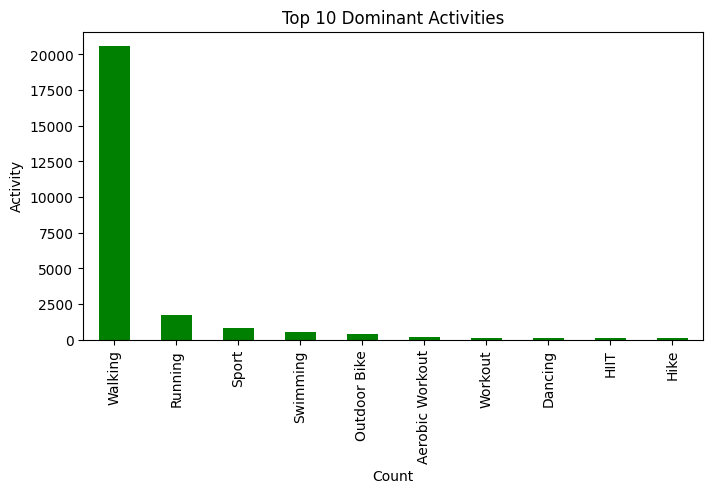

In [27]:
activity_counts = train['dominant_activity'].value_counts()
top_5_activities = activity_counts.head(10)

plt.figure(figsize=(8, 4))
top_5_activities.plot(kind='bar', color='green')
plt.title('Top 10 Dominant Activities')
plt.xlabel('Count')
plt.ylabel('Activity')
plt.show()

### Function 1: Summarize Columns with rolling Mean

The `summarize_columns_rolling_mean` function computes the rolling mean for a set of columns in the `train` DataFrame based on a specified prefix and window size.

1. **Logging Setup**:
   - The logging configuration is set to display debug-level messages with timestamps and severity levels.

2. **Function Definition**: `summarize_columns_rolling_mean(df, column_prefix, window_size=12)`
   - **Parameters**:
     - `df`: The input DataFrame containing the data.
     - `column_prefix`: The prefix of the columns to include for summarization (e.g., `'bg'`).
     - `window_size`: The number of columns to group together for calculating the rolling mean (default is 12).

3. **Logging the Summarization Process**:
   - The function logs the start of the summarization process, indicating which columns will be summarized using the rolling mean.

4. **Identifying Columns to Summarize**:
   - It identifies columns in the DataFrame that start with the specified `column_prefix`.

5. **Computing the Rolling Mean**:
   - The function processes columns in groups of size `window_size`.
   - For each group of columns, the rolling mean is calculated along axis 1 (i.e., row-wise), using the `mean(axis=1)` function.
   - The new column is named after the last column in the group (i.e., `cols_to_mean[-1]`).

6. **Creating the Summarized DataFrame**:
   - A new DataFrame (`summarized_df`) is created with the rolling mean values, and the columns that were processed are dropped from the original DataFrame.

7. **Concatenating the Results**:
   - The summarized DataFrame is concatenated to the original DataFrame, and the resulting DataFrame is returned.

8. **Logging the Completion**:
   - The function logs that the summarization is complete and the DataFrame has been updated.

### Purpose

This function is useful for summarizing a set of related columns (e.g., sensor readings or time series data) by calculating a rolling mean over a specified window size, making it easier to detect trends and patterns in the data.

### Example Output

The result of the function will be a DataFrame where the original columns (starting with `column_prefix`) have been replaced with new columns representing their rolling mean values, and any unnecessary columns have been dropped.


In [28]:
import pandas as pd
import logging

# Set up logging configuration
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

def summarize_columns_rolling_mean(df, column_prefix, window_size=12):
    """
    Summarizes columns by computing the rolling mean over specified intervals.
    
    Parameters:
    - df: DataFrame containing the data.
    - column_prefix: Prefix of the columns to summarize (e.g., 'bg').
    - window_size: Number of columns to group together for mean calculation.
    
    Returns:
    - DataFrame with summarized columns by rolling mean.
    """
    logging.info(f"Summarizing columns starting with {column_prefix} using rolling mean (window size: {window_size})")
    
    # Find all columns starting with the specified prefix
    columns = [col for col in df.columns if col.startswith(column_prefix)]
    
    new_column_data = {}
    
    for i in range(len(columns) // window_size):
        cols_to_mean = columns[i * window_size:(i + 1) * window_size]
        
        mean_value = df[cols_to_mean].mean(axis=1)
        new_column_name = f"{cols_to_mean[-1]}"
        new_column_data[new_column_name] = mean_value
    
    summarized_df = pd.DataFrame(new_column_data)
    logging.info(f"Created summarized DataFrame with rolling mean columns")
    
    df = df.drop(columns=columns, errors='ignore')
    df = pd.concat([df, summarized_df], axis=1)
    
    logging.info(f"Updated DataFrame after summarization of {column_prefix}")
    return df



### Function 2: Summarize Columns with Sum


The `summarize_columns_sum` function computes the sum for a set of columns in the `train` DataFrame based on a specified prefix and window size.

1. **Logging Setup**:
   - The logging configuration is set to display debug-level messages, including timestamps and severity levels.

2. **Function Definition**: `summarize_columns_sum(df, column_prefix, window_size=12)`
   - **Parameters**:
     - `df`: The input DataFrame containing the data.
     - `column_prefix`: The prefix of the columns to include for summarization (e.g., `'insulin'`).
     - `window_size`: The number of columns to group together for calculating the sum (default is 12).

3. **Logging the Summarization Process**:
   - The function logs the start of the summarization process, specifying which columns will be summarized using the sum.

4. **Identifying Columns to Summarize**:
   - It identifies columns in the DataFrame that start with the specified `column_prefix`.

5. **Computing the Sum**:
   - The function processes columns in groups of size `window_size`.
   - For each group of columns, the sum is calculated row-wise (i.e., summing across columns for each row) using the `sum(axis=1)` function.
   - The new column is named after the last column in the group (i.e., `cols_to_sum[-1]`).

6. **Creating the Summarized DataFrame**:
   - A new DataFrame (`summarized_df`) is created with the sum values, and the columns that were processed are dropped from the original DataFrame.

7. **Concatenating the Results**:
   - The summarized DataFrame is concatenated with the original DataFrame, and the resulting DataFrame is returned.

8. **Logging the Completion**:
   - The function logs that the summarization is complete and the DataFrame has been updated.

### Purpose

This function is useful for summari columns (e.g., sensor readings or time-series data) by calculating their sum over a specified window size. This can help aggregate data over intervals, making it ea and the original columns are dropped.


In [29]:
def summarize_columns_sum(df, column_prefix, window_size=12):
    """
    Summarizes columns by computing the sum over specified intervals.
    
    Parameters:
    - df: DataFrame containing the data.
    - column_prefix: Prefix of the columns to summarize (e.g., 'insulin').
    - window_size: Number of columns to group together for sum calculation.
    
    Returns:
    - DataFrame with summarized columns by sum.
    """
    logging.info(f"Summarizing columns starting with {column_prefix} using sum (window size: {window_size})")
    
    columns = [col for col in df.columns if col.startswith(column_prefix)]
    
    new_column_data = {}
    
    for i in range(len(columns) // window_size):
        cols_to_sum = columns[i * window_size:(i + 1) * window_size]
        
        sum_value = df[cols_to_sum].sum(axis=1)
        new_column_name = f"{cols_to_sum[-1]}"
        new_column_data[new_column_name] = sum_value
    
    summarized_df = pd.DataFrame(new_column_data)
    logging.info(f"Created summarized DataFrame with sum columns")
    
    df = df.drop(columns=columns, errors='ignore')
    df = pd.concat([df, summarized_df], axis=1)
    
    logging.info(f"Updated DataFrame after summarization of {column_prefix}")
    return df


In [30]:
def summarize_all_columns(df):
    logging.info("Starting summarization of all columns")
    
    df = summarize_columns_rolling_mean(df, column_prefix='bg-', window_size=12)
    df = summarize_columns_sum(df, column_prefix='insulin', window_size=12)
    df = summarize_columns_sum(df, column_prefix='carbs', window_size=12)
    df = summarize_columns_rolling_mean(df, column_prefix='hr', window_size=12)
    df = summarize_columns_sum(df, column_prefix='steps', window_size=12)
    df = summarize_columns_sum(df, column_prefix='cals', window_size=12)
    
    logging.info("Completed summarization of all columns")
    return df


In [31]:

train_df = summarize_all_columns(train)


2024-11-29 20:15:33,645 - INFO - Starting summarization of all columns
2024-11-29 20:15:33,647 - INFO - Summarizing columns starting with bg- using rolling mean (window size: 12)
2024-11-29 20:15:33,946 - INFO - Created summarized DataFrame with rolling mean columns
2024-11-29 20:15:34,735 - INFO - Updated DataFrame after summarization of bg-
2024-11-29 20:15:34,736 - INFO - Summarizing columns starting with insulin using sum (window size: 12)
2024-11-29 20:15:35,032 - INFO - Created summarized DataFrame with sum columns
2024-11-29 20:15:35,632 - INFO - Updated DataFrame after summarization of insulin
2024-11-29 20:15:35,635 - INFO - Summarizing columns starting with carbs using sum (window size: 12)
2024-11-29 20:15:35,893 - INFO - Created summarized DataFrame with sum columns
2024-11-29 20:15:36,342 - INFO - Updated DataFrame after summarization of carbs
2024-11-29 20:15:36,347 - INFO - Summarizing columns starting with hr using rolling mean (window size: 12)
2024-11-29 20:15:36,649 

In [32]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177024 entries, 0 to 177023
Data columns (total 43 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   p_num              177024 non-null  int64  
 1   bg+1:00            177024 non-null  float64
 2   hour_sin           177024 non-null  float64
 3   hour_cos           177024 non-null  float64
 4   minute_sin         177024 non-null  float64
 5   minute_cos         177024 non-null  float64
 6   dominant_activity  25019 non-null   object 
 7   bg-5:00            174459 non-null  float64
 8   bg-4:00            174639 non-null  float64
 9   bg-3:00            174839 non-null  float64
 10  bg-2:00            175151 non-null  float64
 11  bg-1:00            175570 non-null  float64
 12  bg-0:00            176198 non-null  float64
 13  insulin-5:00       177024 non-null  float64
 14  insulin-4:00       177024 non-null  float64
 15  insulin-3:00       177024 non-null  float64
 16  in

In [33]:
test_df = summarize_all_columns(test)

2024-11-29 20:16:02,695 - INFO - Starting summarization of all columns
2024-11-29 20:16:02,697 - INFO - Summarizing columns starting with bg- using rolling mean (window size: 12)
2024-11-29 20:16:02,712 - INFO - Created summarized DataFrame with rolling mean columns
2024-11-29 20:16:02,727 - INFO - Updated DataFrame after summarization of bg-
2024-11-29 20:16:02,728 - INFO - Summarizing columns starting with insulin using sum (window size: 12)
2024-11-29 20:16:02,741 - INFO - Created summarized DataFrame with sum columns
2024-11-29 20:16:02,751 - INFO - Updated DataFrame after summarization of insulin
2024-11-29 20:16:02,752 - INFO - Summarizing columns starting with carbs using sum (window size: 12)
2024-11-29 20:16:02,765 - INFO - Created summarized DataFrame with sum columns
2024-11-29 20:16:02,774 - INFO - Updated DataFrame after summarization of carbs
2024-11-29 20:16:02,775 - INFO - Summarizing columns starting with hr using rolling mean (window size: 12)
2024-11-29 20:16:02,788 

In [34]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3644 entries, 0 to 3643
Data columns (total 43 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 3644 non-null   object 
 1   p_num              3644 non-null   int64  
 2   hour_sin           3644 non-null   float64
 3   hour_cos           3644 non-null   float64
 4   minute_sin         3644 non-null   float64
 5   minute_cos         3644 non-null   float64
 6   dominant_activity  390 non-null    object 
 7   bg-5:00            3592 non-null   float64
 8   bg-4:00            3585 non-null   float64
 9   bg-3:00            3572 non-null   float64
 10  bg-2:00            3541 non-null   float64
 11  bg-1:00            3537 non-null   float64
 12  bg-0:00            3580 non-null   float64
 13  insulin-5:00       3644 non-null   float64
 14  insulin-4:00       3644 non-null   float64
 15  insulin-3:00       3644 non-null   float64
 16  insulin-2:00       3644 

In [35]:
train_df.isna().sum()

p_num                     0
bg+1:00                   0
hour_sin                  0
hour_cos                  0
minute_sin                0
minute_cos                0
dominant_activity    152005
bg-5:00                2565
bg-4:00                2385
bg-3:00                2185
bg-2:00                1873
bg-1:00                1454
bg-0:00                 826
insulin-5:00              0
insulin-4:00              0
insulin-3:00              0
insulin-2:00              0
insulin-1:00              0
insulin-0:00              0
carbs-5:00                0
carbs-4:00                0
carbs-3:00                0
carbs-2:00                0
carbs-1:00                0
carbs-0:00                0
hr-5:00               43788
hr-4:00               43704
hr-3:00               43611
hr-2:00               43515
hr-1:00               43385
hr-0:00               43265
steps-5:00                0
steps-4:00                0
steps-3:00                0
steps-2:00                0
steps-1:00          

### Data Preprocessing Summary

### 1. Handling Missing Values for Different Columns
The preprocessing pipeline addresses missing values based on the type and characteristics of the columns, ensuring data consistency and logical integrity. Different methods are applied depending on the nature of the data and the assumptions about missing values.

---

### 2. Functionality Breakdown

#### **For Blood Glucose (`bg-`) and Heart Rate (`hr`) Columns:**
- **Method**: Missing values are filled using **linear interpolation**.
- **Purpose**: 
  - Estimates missing values based on neighboring observations within a row.
  - Ensures a smooth and consistent representation of trends, preserving logical continuity.
  - Reflects the assumption that heart rate (`hr`) and blood glucose (`bg-`) remain within a realistic range and are relatively stable throughout the period, rather than dropping to zero.
- **Implementation**:
  - Interpolation is applied across rows (`axis=1`), meaning values are calculated horizontally for each individual data entry.
  - This approach ensures the physiological data remains accurate and avoids abrupt or unrealistic drops to zero.

---

#### **For Insulin, Calories, Steps, and Carbs Columns (`insulin`, `cals`, `steps`, `carbs`):**
- **Method**: Missing values are replaced with `0`.
- **Purpose**:
  - Reflects the assumption that:
    - **Insulin**: Missing data indicates no insulin was administered during that period.
    - **Calories**: Missing data indicates no calorie intake was recorded.
    - **Steps**: Missing data indicates no steps were taken.
    - **Carbs**: Missing data indicates no carbohydrate intake occurred.
  - This approach avoids introducing artificial trends or patterns while maintaining logical consistency in activity or intake-related data.

------------

### Advantages of the Approach
- **Realistic Assumptions**: Each column is handled in a way that reflects its nature:
  - `bg-` and `hr`: Interpolated to maintain realistic and continuous physiological trends.
  - `insulin`, `cals`, `steps`, and `carbs`: Filled with `0` to indicate inactivity or absence of measurements.
- **Accuracy**: Interpolation ensures logical trends in physiological data, while `0` replacements simplify categorical and activity-related data.
- **Consistency**: Ensures the dataset is complete and ready for downstream analysis or modeling.


In [42]:
# Define related column sets (bg_cols, insulin_cols, cals_cols, steps_cols, carbs_cols, hr_cols)
bg_cols = [col for col in train_df.columns if col.startswith('bg-')]
hr_cols = [col for col in train_df.columns if col.startswith('hr')]

carbs_cols = [col for col in test_df.columns if col.startswith('carbs')]
insulin_cols = [col for col in test_df.columns if col.startswith('insulin')]
steps_cols = [col for col in test_df.columns if col.startswith('steps')]
cals_cols = [col for col in test_df.columns if col.startswith('cals')]

In [53]:
# Replace NaN with a placeholder string like 'Unknown' or any desired value
train_df = train_df.drop('dominant_activity'.fillna('Unknown')
test_df['dominant_activity'] = test_df['dominant_activity'].fillna('Unknown')

In [54]:

# Combine all relevant columns
fill_zero_cols = carbs_cols + insulin_cols + steps_cols + cals_cols

# Fill missing values with 0 for these columns
train_df[fill_zero_cols] = train_df[fill_zero_cols].fillna(0)
test_df[fill_zero_cols] = test_df[fill_zero_cols].fillna(0)

In [55]:
time_series_cols = bg_cols + hr_cols



# Step 1: Linear interpolation for missing values in bg_cols and hr_cols
train_df[time_series_cols] = train_df[time_series_cols].interpolate(
    method='linear', axis=1, limit_direction='both')
test_df[time_series_cols] = test_df[time_series_cols].interpolate(
    method='linear', axis=1, limit_direction='both')

### Checking for Remaining Missing Values

After applying the missing value imputation strategies, we verify if there are any remaining missing values in the `train_cleaned` and `test_cleaned` datasets.

---#

### **Purpose of the Check**
#### **Objective**:
- Ensure that all missing values have been effectively handled during the preprocessing steps.

#### **Expected Result**:
- Both outputs should print `False`, indicating that there are no missing values in the dates in test_cleaned


In [56]:
print(train_df.isnull().sum().any())

print(test_df.isnull().sum().any())

False
False


## Distribution Analysis and Skewness Transformation

#### 1. **Initial Distribution Check**
- **Objective**: Visualize the distribution of the target variable (`bg+1:00`) and calculate its skewness.
- **Steps**:
  - A histogram with kernel density estimation (KDE) was plotted.
  - Skewness was calculated to assess the asymmetry of the distribution.#

#### **Result**:
- Initial skewne7ss: **1.0** (indicating a right-skewed distribution).#

---

### 2. **Log Transformation**
- **Objective**: Reduce skewness and normalize the distribution.
- **Steps**:
  - Applied a `log1p` transformation (`log(1 + x)`) to the target variable.
  - Plotted the transformed distribution and recalculat#ed skewness.

#### **Result**:
- Transformed skewness: **0.21** (indicating a nearly symmetrical dist#ribution).

---

### 3. **Why Transform?**
- Reducing skewness improves the normality of data, which benefits many machine learning models that assume normally distributed inputs or outputs.


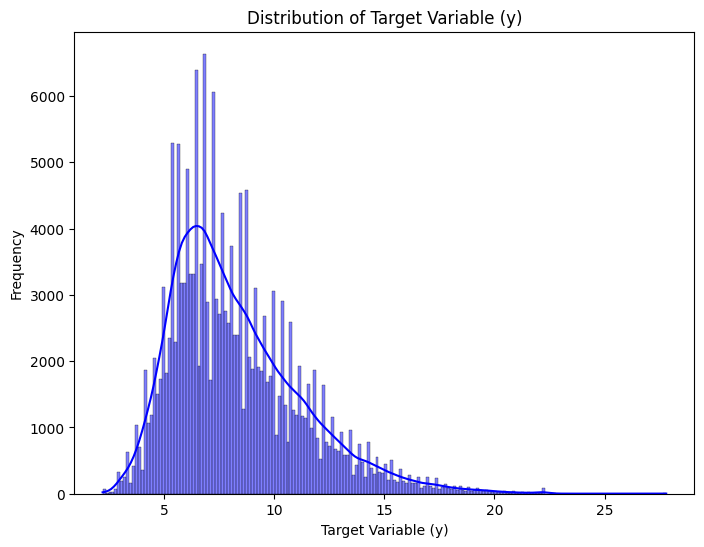

Skewness of Target Variable (y) before transformation: 1.07


In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew 

# Plot histogram
plt.figure(figsize=(8, 6))
sns.histplot(train_df['bg+1:00'], kde=True, color='blue')
plt.title('Distribution of Target Variable (y)')
plt.xlabel('Target Variable (y)')
plt.ylabel('Frequency')
plt.show()

# Calculate skewness
skewness_value = skew(train_df['bg+1:00'])
print(f"Skewness of Target Variable (y) before transformation: {skewness_value:.2f}")

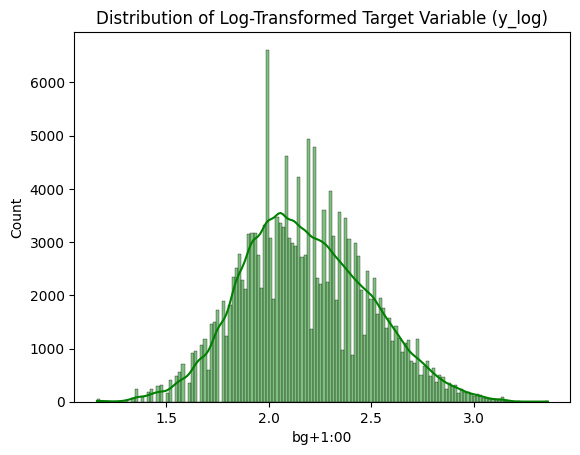

Skewness after Log Transformation: 0.21


In [58]:
# Log transformation
train_df['bg+1:00'] = np.log1p(train_df['bg+1:00'])

# Plot histogram of transformed target
sns.histplot(train_df['bg+1:00'], kde=True, color='green')
plt.title('Distribution of Log-Transformed Target Variable (y_log)')
plt.show()

# Check skewness after transformation
log_skewness_value = skew(train_df['bg+1:00'])
print(f"Skewness after Log Transformation: {log_skewness_value:.2f}")

# Checking for Missing Values in Train and Test DataFrames

---

### **Purpose**
- Verify the presence of missing values in both the training and test datasets before proceeding with model training.
- Ensure data quality, as missing values can negatively impact model performance and lead to biased results.{test_missing}")


In [67]:
# Check for missing values in train_filtered
missing_train = train_df.isnull().sum()
print("Missing values in train:")
print(missing_train[missing_train > 0])

# Check for missing values in test_df
missing_test = test_df.isnull().sum()
print("Missing values in test_df:")
print(missing_test[missing_test > 0])

# Summary
if missing_train.sum() == 0 and missing_test.sum() == 0:
    print("Both datasets are complete: No missing values.")
else:
    print("Missing values found. Please address them.")

Missing values in train:
Series([], dtype: int64)
Missing values in test_df:
Series([], dtype: int64)
Both datasets are complete: No missing values.


### Splitting Data into Features and Targetirget:**

- **`X`**: The feature matrix created by dropping the target column (`bg+1:00`) and the participant number column (`p_num`) from the DataFrame.
- **`y`**: The target vector, which contains the values from the `bg+1:00` column.

---

#### **Splitting the Data into Training and Validation Sets:**

- The dataset is split into training and validation sets using `train_test_split` from `sklearn.model_selection`.
- The `test_size=0.2` argument indicates that **20%** of the data will be used for validation, while the remaining **80%** will be used for training.
- `random_state=42` ensures reproducibit_size=0.2, random_state=42)


In [70]:
target_column = 'bg+1:00'  
X = train_df.drop(columns=[target_column, 'p_num'])
y = train_df[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [71]:
y

0         2.667228
1         2.624669
2         2.803360
3         2.760010
4         2.617396
            ...   
177019    2.493205
177020    2.476538
177021    2.459589
177022    2.442347
177023    2.415914
Name: bg+1:00, Length: 177024, dtype: float64

### Preprocessing Numeric and Categorical Features

#### 1. **Feature Identification**
- **Numeric Features**: Identified columns with numeric data types (`int64`, `int32`, `float64`).
- **Categorical Features**: Identified columns with object/string data type#### **2. Preprocessing Steps**
##### **For Numeric Features**:
- Applied `RobustScaler` to scale numeric columns.
- Scales data by removing the **median** and scaling using the **interquartile range**, making it robust to outliers.

##### **For Categorical Features**:
- Applied `OrdinalEncoder` to encode categorical columns into numeric format.

---

#### **3. ColumnTransformer**
- Combined numeric and categorical transformations using `ColumnTransformer` for streamlined preprocessing.

---

#### **4. Fit and Transform**
- **Training Data**: 
  - `preprocessor.fit_transform(X_train)` applies transformations to the training data.
- **Validation Data**: 
  - `preprocessor.transform(X_test)` applies the same transformations to the validation data.

---

#### **Why This Approach?**
- Handles numeric and categorical features efficiently in a single pipeline.
- Scales numeric features while preserving the robustness against outliers.
- Encodes categorical features for compatibility with machine learning models.l_features)


In [104]:
from sklearn.preprocessing import OrdinalEncoder, RobustScaler
from sklearn.compose import ColumnTransformer

# Identify numeric columns in training data
numeric_features = X.select_dtypes(include=['int64', 'int32', 'float64']).columns.tolist()

# Identify categorical columns in training data
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Display numeric and categorical columns
print("Numeric Columns:", numeric_features)
print("Categorical Columns:", categorical_features)

# Apply the scaler to the numeric columns and ordinal encoding to categorical columns
numeric_transformer = RobustScaler()
categorical_transformer = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Combine both transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),  # Apply RobustScaler to numeric columns
        ('cat', categorical_transformer, categorical_features)  # Apply OrdinalEncoder to categorical columns
    ]
)

# Fit and transform the training data
X_train_processed = preprocessor.fit_transform(X_train)

# Transform the test data using the fitted preprocessor
X_test_processed = preprocessor.transform(X_test)  # Works without issues for unseen categories

# Verify processed data
print(X_train_processed)


Numeric Columns: ['hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'bg-5:00', 'bg-4:00', 'bg-3:00', 'bg-2:00', 'bg-1:00', 'bg-0:00', 'insulin-5:00', 'insulin-4:00', 'insulin-3:00', 'insulin-2:00', 'insulin-1:00', 'insulin-0:00', 'carbs-5:00', 'carbs-4:00', 'carbs-3:00', 'carbs-2:00', 'carbs-1:00', 'carbs-0:00', 'hr-5:00', 'hr-4:00', 'hr-3:00', 'hr-2:00', 'hr-1:00', 'hr-0:00', 'steps-5:00', 'steps-4:00', 'steps-3:00', 'steps-2:00', 'steps-1:00', 'steps-0:00', 'cals-5:00', 'cals-4:00', 'cals-3:00', 'cals-2:00', 'cals-1:00', 'cals-0:00']
Categorical Columns: ['dominant_activity']
[[ 3.53553391e-01 -6.12372436e-01  1.00000000e+00 ...  1.66417072e-01
   1.63143124e-01  1.40000000e+01]
 [ 6.12372436e-01 -3.53553391e-01 -5.66553890e-16 ...  2.07038562e-01
   2.24134705e-01  1.40000000e+01]
 [-6.83012702e-01 -1.83012702e-01 -5.66553890e-16 ... -1.35248970e+00
  -1.35229186e+00  1.40000000e+01]
 ...
 [-8.65956056e-17  7.07106781e-01  5.00000000e-01 ...  7.59266192e-01
   2.19644528e-01  1.40

In [77]:
print(f"Shapes: {X_train_processed.shape}, {y_train.shape}")
print(f"Missing values in X: {np.isnan(X_train_processed).sum()}")
print(f"Missing values in y: {np.isnan(y_train).sum()}")


Shapes: (141619, 41), (141619,)
Missing values in X: 0
Missing values in y: 0


## Training Ensemble Models (XGBoost, LightGBM, RandomForest)

This section demonstrates the training process of three popular machine learning models: **XGBoost**, **LightGBM**, and **RandomForest**. These models are trained using **5-fold cross-validation** to evaluate their performance and identify the best-performing model for each algorithm.

### 1. **XGBoost (XGB)**

**XGBoost** is a powerful gradient boosting algorithm that excels in both classification and regression tasks. In this step, we train the XGBoost model using the training data and validate it on each fold of the cross-validation process.

- **Evaluation Metric**: We use **RMSE (Root Mean Squared Error)**, **MAE (Mean Absolute Error)**, and **R² (R-squared)** to evaluate the model's performance.
- **Training Process**: For each fold, we fit the model on the training set, predict on the validation set, and calculate the performance metrics.
- **Model Saving**:After training on each fold, the XGBoost model is saved as a `.pkl` file for future use.

--------
### 2. **LightGBM (LGB)**

**LightGBM** is a gradient boosting framework that is optimized for speed and efficiency, especially when working with large datasets. It is trained using a **5-fold cross-validation** process, similar to XGBoost.

- **Evaluation Metric**: We use **RMSE (Root Mean Squared Error)**, **MAE (Mean Absolute Error)**, and **R² (R-squared)** to evaluate the model's performance.
- **Training Process**: The model is trained on the training set in each fold, and its performance is evaluated using the validation set.
- **Model Saving**: After each fold, the trained model is saved for later use, similar to how the XGBoost model is handled.
##
---

# 3. **RandomForest (RF)**

**RandomForest** is an ensemble learning method that builds multiple decision trees and combines them to enhance accuracy and prevent overfitting. This model is trained using the same **5-fold cross-validation** process as XGBoost and LightGBM.

- **Evaluation Metric**: The same performance metrics (**RMSE**, **MAE**, and **R²**) are used to evaluate the model's performance.
- **Training Process**: The RandomForest model is trained on the training data for each fold, and its performance is evaluated using the validation set.
- **Model Saving**: After training, the RandomForest model is saved after each fold to ensure it can be used later for predictions or further ##analysis.

---

# 4. **Model Performance Evaluation**

After training each of the three models (XGBoost, LightGBM, RandomForest), we evaluate their performance using the following metrics:

- **RMSE (Root Mean Squared Error)**: Measures the average magnitude of the errors in predictions.
- **MAE (Mean Absolute Error)**: Measures the average absolute error between predicted and actual values.
- **R² (R-squared)**: Indicates how well the model explains the variance in the target variable.

We track these metrics for each model and each fold, storing the best-performing mode##l for each algorithm.

---

# 5. **Model Saving**

After training and evaluating each model, the best models are saved based on their RMSE scores. These models are serialized using **pickle** and saved as `.pkl` files for future use ini### Conclusion

This process enables the training, evaluation, and saving of three different models—**XGBoost**, **LightGBM**, and **RandomForest**—using a **5-fold cross-validation** approa totalling 15 models.h. The performance of each model is closely monitorede.
le:
    pickle.dump(best_model, file)


In [78]:
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import pickle
# Set up K-Fold Cross Validation

kf = KFold(n_splits=5, shuffle=True)

# Initialize lists to store metrics for each fold
rmse_scores = {'XGBoost': [], 'LightGBM': [], 'RandomForest': []}
mae_scores = {'XGBoost': [], 'LightGBM': [], 'RandomForest': []}
r2_scores = {'XGBoost': [], 'LightGBM': [], 'RandomForest': []}
all_residuals = []

# Initialize lists to store predictions from all models for ensemble calculation
ensemble_predictions = []

# Initialize variable to store the best model
best_model_dict = {'XGBoost': None, 'LightGBM': None, 'RandomForest': None, 'CatBoost': None}
best_rmse_dict = {'XGBoost': float('inf'), 'LightGBM': float('inf'), 'RandomForest': float('inf')}

# Initialize models
models = {
    'XGBoost': xgb.XGBRegressor(tree_method='hist', objective='reg:squarederror', n_estimators=3000),
    'LightGBM': lgb.LGBMRegressor(n_estimators=3000, verbose=-1),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

# Training Loop with K-Fold Cross-Validation
fold = 1
plt.figure(figsize=(10, 6))

# Perform k-fold cross-validation
for train_index, val_index in kf.split(X_train_processed):
    # Split data into train and validation sets for the current fold
    X_train_fold, X_val_fold = X_train_processed[train_index], X_train_processed[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Loop through all models
    for name, model in models.items():
        print(f"Training {name} on Fold {fold}...")
        
        if name == 'XGBoost':
            # Create eval set for XGBoost
            evals = [(X_train_fold, y_train_fold), (X_val_fold, y_val_fold)]
            model.fit(X_train_fold, y_train_fold, eval_metric="rmse")
        else:
            # Train the model on the current fold’s data (other models)
            model.fit(X_train_fold, y_train_fold)

        # Predictions
        y_pred_log = model.predict(X_val_fold)
        y_pred = np.expm1(y_pred_log)  # Reverse log1p for predictions
        y_val_actual = np.expm1(y_val_fold)  # Reverse log1p for the actual values
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_val_actual, y_pred))
        mae = mean_absolute_error(y_val_actual, y_pred)
        r2 = r2_score(y_val_actual, y_pred)
        
        # Calculate residuals
        residuals = y_val_actual - y_pred
        all_residuals.extend(residuals)

        # Store metrics
        rmse_scores[name].append(rmse)
        mae_scores[name].append(mae)
        r2_scores[name].append(r2)
        
        # Track the best model based on RMSE
        if rmse < best_rmse_dict[name]:
            best_rmse_dict[name] = rmse
            best_model_dict[name] = model  # Save the best model

        # Print model metrics for the current fold
        print(f"{name} - Fold {fold} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

        
        # Save the model for the current fold
        with open(f"{name}_model_fold{fold}.pkl", "wb") as file:
            pickle.dump(model, file)
        print(f"Saved {name} model for Fold {fold}.")
    

    fold += 1


Training XGBoost on Fold 1...
XGBoost - Fold 1 - RMSE: 1.1243, MAE: 0.7478, R²: 0.8608
Saved XGBoost model for Fold 1.
Training LightGBM on Fold 1...
LightGBM - Fold 1 - RMSE: 1.1958, MAE: 0.8293, R²: 0.8425
Saved LightGBM model for Fold 1.
Training RandomForest on Fold 1...
RandomForest - Fold 1 - RMSE: 1.3705, MAE: 0.8755, R²: 0.7931
Saved RandomForest model for Fold 1.
Training XGBoost on Fold 2...
XGBoost - Fold 2 - RMSE: 1.1378, MAE: 0.7540, R²: 0.8539
Saved XGBoost model for Fold 2.
Training LightGBM on Fold 2...
LightGBM - Fold 2 - RMSE: 1.2105, MAE: 0.8364, R²: 0.8346
Saved LightGBM model for Fold 2.
Training RandomForest on Fold 2...
RandomForest - Fold 2 - RMSE: 1.3884, MAE: 0.8791, R²: 0.7825
Saved RandomForest model for Fold 2.
Training XGBoost on Fold 3...
XGBoost - Fold 3 - RMSE: 1.1085, MAE: 0.7418, R²: 0.8616
Saved XGBoost model for Fold 3.
Training LightGBM on Fold 3...
LightGBM - Fold 3 - RMSE: 1.2013, MAE: 0.8308, R²: 0.8375
Saved LightGBM model for Fold 3.
Training 

<Figure size 1000x600 with 0 Axes>

In [91]:
import numpy as np
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model_names = ['XGBoost', 'LightGBM', 'RandomForest'] 
num_folds = 5  

# Initialize lists to store metrics for each fold
rmse_scores = []
mae_scores = []
r2_scores = []
all_residuals = []  

# Loop through each fold
for fold in range(1, num_folds + 1):
    print(f"Evaluating Ensemble for Fold {fold}...")
    
    # Initialize a list to store predictions for the current fold
    fold_predictions = []
    
    # Load models for the current fold and make predictions
    for model_name in model_names:
        model_file = f'/kaggle/working/{model_name}_model_fold{fold}.pkl'
        
        # Load the model for the current fold
        with open(model_file, 'rb') as f:
            model = pickle.load(f)
        
        # Predict using the model for this fold 
        y_pred_log = model.predict(X_test_processed)  
        y_pred = np.expm1(y_pred_log) 
        
        fold_predictions.append(y_pred)
    
    # Ensemble the predictions (taking the average across models)
    ensemble_predictions = np.mean(fold_predictions, axis=0)

    # Reverse log1p transformation for actual values if applicable
    y_val_actual = np.expm1(y_test)  # Reverse log1p for actual values

    # Calculate metrics for the ensemble
    rmse = np.sqrt(mean_squared_error(y_val_actual, ensemble_predictions))
    mae = mean_absolute_error(y_val_actual, ensemble_predictions)
    r2 = r2_score(y_val_actual, ensemble_predictions)

    # Store metrics for the fold
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)

     #Calculate residuals (errors) for the fold and store them
    residuals = y_val_actual - ensemble_predictions
    all_residuals.extend(residuals)

    # Print metrics for the fold
    print(f"Fold {fold} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

# Calculate average metrics across all folds
avg_rmse = np.mean(rmse_scores)
avg_mae = np.mean(mae_scores)
avg_r2 = np.mean(r2_scores)

# Print the average ensemble metrics across all folds
print(f"Average Ensemble Metrics Across Folds - RMSE: {avg_rmse:.4f}, MAE: {avg_mae:.4f}, R²: {avg_r2:.4f}")


Evaluating Ensemble for Fold 1...
Fold 1 - RMSE: 1.1401, MAE: 0.7530, R²: 0.8563
Evaluating Ensemble for Fold 2...
Fold 2 - RMSE: 1.1385, MAE: 0.7518, R²: 0.8567
Evaluating Ensemble for Fold 3...
Fold 3 - RMSE: 1.1434, MAE: 0.7543, R²: 0.8555
Evaluating Ensemble for Fold 4...
Fold 4 - RMSE: 1.1381, MAE: 0.7511, R²: 0.8568
Evaluating Ensemble for Fold 5...
Fold 5 - RMSE: 1.1401, MAE: 0.7546, R²: 0.8563
Average Ensemble Metrics Across Folds - RMSE: 1.1400, MAE: 0.7530, R²: 0.8563


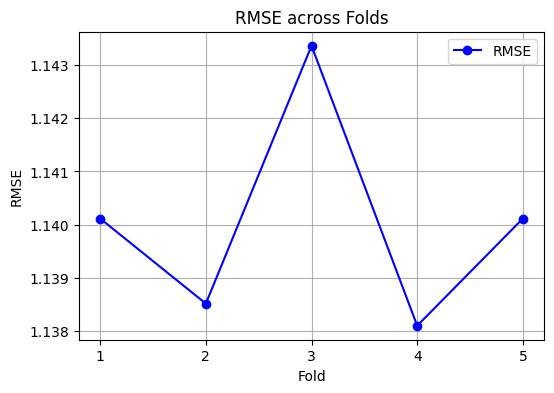

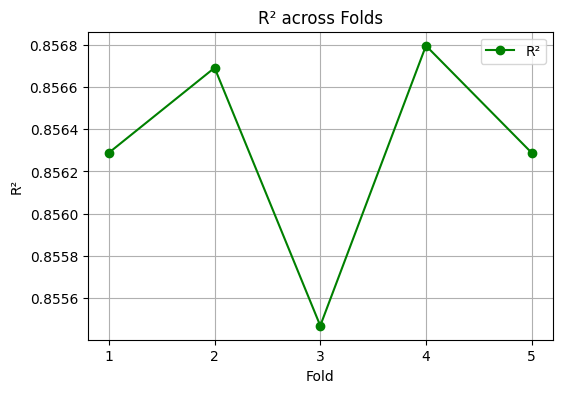

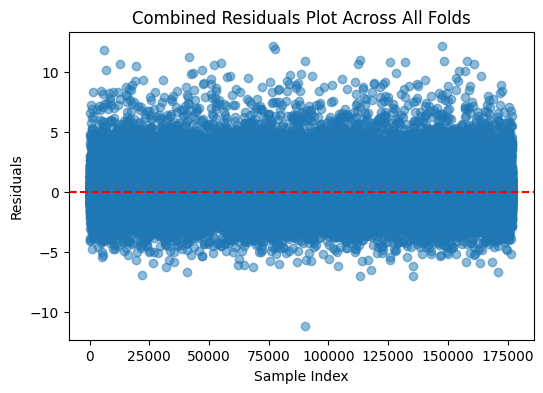

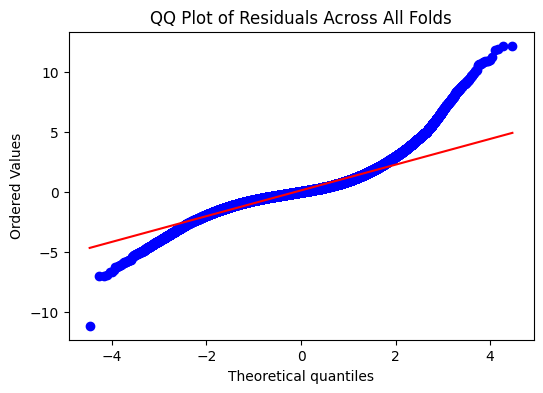

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Plot RMSE across all folds
plt.figure(figsize=(6, 4))
plt.plot(range(1, num_folds + 1), rmse_scores, marker='o', label='RMSE', color='blue')
plt.title("RMSE across Folds")
plt.xlabel("Fold")
plt.ylabel("RMSE")
plt.xticks(range(1, num_folds + 1))
plt.legend()
plt.grid(True)
plt.show()

# Plot R² across all folds
plt.figure(figsize=(6, 4))
plt.plot(range(1, num_folds + 1), r2_scores, marker='o', label='R²', color='green')
plt.title("R² across Folds")
plt.xlabel("Fold")
plt.ylabel("R²")
plt.xticks(range(1, num_folds + 1))
plt.legend()
plt.grid(True)
plt.show()

# Optionally, plot combined residuals across all folds
plt.figure(figsize=(6, 4))
plt.scatter(range(len(all_residuals)), all_residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Combined Residuals Plot Across All Folds")
plt.xlabel("Sample Index")
plt.ylabel("Residuals")
plt.show()

# QQ plot for combined residuals across all folds
plt.figure(figsize=(6, 4))
stats.probplot(all_residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals Across All Folds")
plt.show()

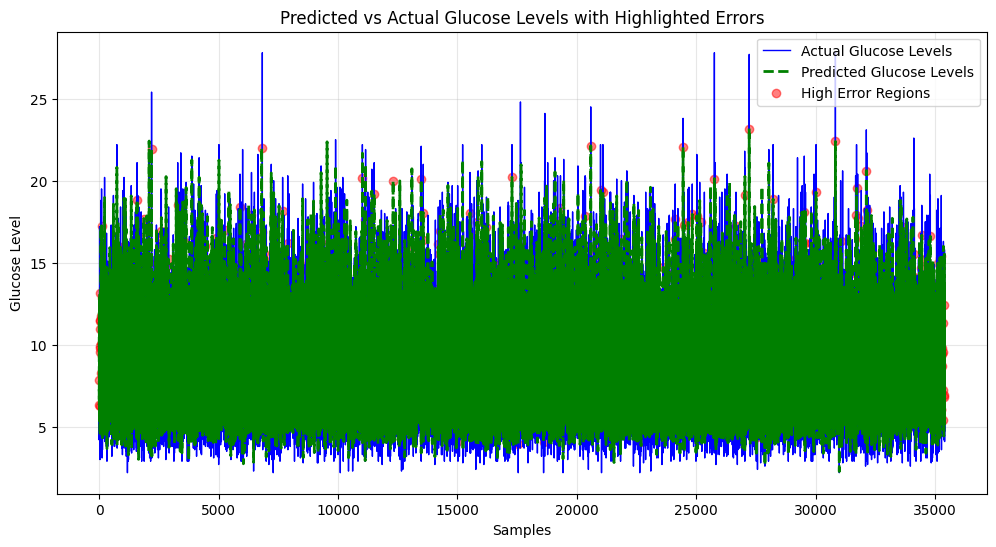

In [103]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_val_actual and ensemble_predictions are already available
# Calculate absolute error between actual and predicted glucose levels
absolute_error = np.abs(y_val_actual.values - ensemble_predictions)

# Define a threshold for highlighting large errors (adjust as necessary)
error_threshold = np.percentile(absolute_error, 90)  # Highlight the top 10% largest errors

# Create a mask for where the error is above the threshold
highlight_mask = absolute_error > error_threshold

# Plotting the Actual and Predicted Glucose Levels
plt.figure(figsize=(12, 6))

# Plot Actual Glucose Levels
plt.plot(y_val_actual.values, label='Actual Glucose Levels', color='blue', linestyle='-', linewidth=1)

# Plot Predicted Glucose Levels
plt.plot(ensemble_predictions, label='Predicted Glucose Levels', color='green', linestyle='--', linewidth=2)

# Highlight the regions where the error is large
plt.scatter(np.where(highlight_mask)[0], ensemble_predictions[highlight_mask], color='red', alpha=0.5, label='High Error Regions')

# Labels and title
plt.xlabel('Samples')
plt.ylabel('Glucose Level')
plt.title('Predicted vs Actual Glucose Levels with Highlighted Errors')

# Displaying legend and grid
plt.legend()
plt.grid(alpha=0.3)

# Show the plot
plt.show()


## interference


In [105]:
# Identify numeric columns
test_numeric_columns = test_df.select_dtypes(include=['int64', 'int32', 'float64']).columns.tolist()

# Identify categorical columns
test_categorical_columns = test_df.select_dtypes(include=['object']).columns.tolist()

# Display the results
print("Numeric Columns:", test_numeric_columns)
print("Categorical Columns:", test_categorical_columns)
test_processed = preprocessor.transform(test_df)

Numeric Columns: ['p_num', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'bg-5:00', 'bg-4:00', 'bg-3:00', 'bg-2:00', 'bg-1:00', 'bg-0:00', 'insulin-5:00', 'insulin-4:00', 'insulin-3:00', 'insulin-2:00', 'insulin-1:00', 'insulin-0:00', 'carbs-5:00', 'carbs-4:00', 'carbs-3:00', 'carbs-2:00', 'carbs-1:00', 'carbs-0:00', 'hr-5:00', 'hr-4:00', 'hr-3:00', 'hr-2:00', 'hr-1:00', 'hr-0:00', 'steps-5:00', 'steps-4:00', 'steps-3:00', 'steps-2:00', 'steps-1:00', 'steps-0:00', 'cals-5:00', 'cals-4:00', 'cals-3:00', 'cals-2:00', 'cals-1:00', 'cals-0:00']
Categorical Columns: ['id', 'dominant_activity']


In [107]:
import numpy as np
import pickle
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model_names = ['XGBoost', 'LightGBM', 'RandomForest'] 
num_folds = 5  # Number of folds (you can adjust this depending on your setup)


# Initialize list to store ensemble predictions for each fold
ensemble_predictions_all_folds = []

# Loop through each fold
for fold in range(1, num_folds + 1):
    print(f"Making Predictions Ensemble for Fold {fold}...")
    
    # Initialize a list to store individual model predictions for this fold
    fold_predictions = []
    
    # Loop over each model to make predictions for this fold
    for model_name in model_names:
        model_file = f'/kaggle/working/{model_name}_model_fold{fold}.pkl'  # Path to the model file
        
        # Load the model for the current fold
        with open(model_file, 'rb') as f:
            model = pickle.load(f)
        
        # Predict using the model for this fold
        y_pred_log = model.predict(test_processed)  # test_df is your test dataset
        
        # Reverse the log1p transformation
        y_pred = np.expm1(y_pred_log)  # Apply expm1 to reverse log1p transformation
        
        fold_predictions.append(y_pred)
    
    # Ensemble the predictions (taking the average across models for this fold)
    fold_ensemble_predictions = np.mean(fold_predictions, axis=0)
    
    # Store the ensemble predictions for this fold
    ensemble_predictions_all_folds.append(fold_ensemble_predictions)

# Combine all fold ensemble predictions by averaging them
final_ensemble_predictions = np.mean(ensemble_predictions_all_folds, axis=0)

# Prepare the submission DataFrame
# Assuming 'id' column exists in test_df to uniquely identify each sample
submission_df = pd.DataFrame({
    'id': test_df['id'],  # Replace 'id' with the actual column name if different
    'bg+1:00': final_ensemble_predictions  # Replace 'bg+1:00' with the desired output column name
})

# Display the first few rows of the submission DataFrame
print(submission_df.head())

# Save the final predictions to a CSV file
submission_df.to_csv('submission.csv', index=False)


Making Predictions Ensemble for Fold 1...
Making Predictions Ensemble for Fold 2...
Making Predictions Ensemble for Fold 3...
Making Predictions Ensemble for Fold 4...
Making Predictions Ensemble for Fold 5...
         id    bg+1:00
0  p01_8459   7.647063
1  p01_8460   6.615537
2  p01_8461   7.519720
3  p01_8462  10.033771
4  p01_8463   6.003965
